In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import torchvision.transforms as transforms
import pandas as pd
from skimage import io
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

Подгружаю данные и разбиваю на тестовую и тренировочную выборки

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
y = digits.target
x = digits.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.5, shuffle=False
)

Изображения 8x8, числами от 0 до 16 обозначены цвета (0 - чёрные, 16 - белый, остальные - оттенки серого)

In [ ]:
X_train[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

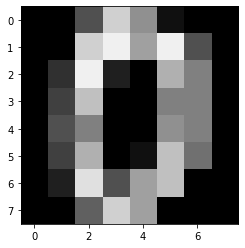

In [ ]:
def draw_digit(features):
    plt.imshow(features.reshape(8, 8), cmap=plt.cm.gray, vmax=16, interpolation='nearest')
draw_digit(X_train[0])

Опишем модель, оптимизатор и функцию потерь

In [ ]:
input_dim = 8
sequence_length = 8
hidden_dim = 64
num_layers = 2
num_classes = 10
learning_rate = 0.005
batch_size = 100
num_epochs = 166
train = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim * sequence_length, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [ ]:
model = RNN(input_dim, hidden_dim, num_layers, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # оптимизатор
criterion = nn.CrossEntropyLoss()

Обучим нейронную сеть:

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (img, num) in enumerate(tqdm(train_loader)):
        img = img.view(-1, 8, 8)
        scores = model(img.float())
        loss = criterion(scores, num)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 9/9 [00:00<00:00, 177.39it/s]


Проверим долю правильных ответов:

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.view(-1, 8, 8)
            scores = model(x.float())
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    model.train()
    return num_correct / num_samples
print(f"Accuracy on train: {check_accuracy(train_loader, model)}")
print(f"Accuracy on test: {check_accuracy(test_loader, model)}")

Accuracy on train: 1.0
Accuracy on test: 0.9488320350646973


Доля правильных ответов на тесте $\approx 0.95$